# load float log

In [1]:
import os
from glob import glob
import yaml

import numpy as np
import pandas as pd

import cognac.float as fl

In [2]:
root_dir = '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin0_bags/'

bag = 'pd_2020-06-10-15-55-17_0'

def load_bag_data(bag_dir):
    files = glob(os.path.join(bag_dir,'*.csv'))
    bdata = {f.split('/')[-1].replace('.csv',''): 
            pd.read_csv(f) for f in files}
    # set date as index:
    for d in bdata:
        #bdata[d] = (bdata[d]
        #            .rename(columns={'time': 'seconds', 'Unnamed: 0': 'time'})
        #            .set_index('time')
        #           )
        # hack till we fix issues upstream
        bdata[d].drop(columns='Unnamed: 0', inplace=True)
        bdata[d] = bdata[d].rename(columns={'time': 'seconds'})
        startDate = pd.to_datetime(bag_dir.split('/')[-1]
                                   .replace('pd_','')
                                   .replace('_0','')
                                  )
        t = startDate + pd.to_timedelta(bdata[d]['seconds'], unit='s')
        bdata[d] = bdata[d].set_index(t)
    return bdata

bdata = load_bag_data(root_dir+bag)

for b, d in bdata.items():
    print(b, list(d))

regulationHeadingSetPoint ['set_point', 'seconds']
fix ['altitude', 'err', 'err_horz', 'err_speed', 'err_time', 'err_track', 'err_vert', 'gdop', 'hdop', 'latitude', 'longitude', 'pdop', 'speed', 'status', 'tdop', 'seconds', 'track', 'vdop']
pistonState ['enable_on', 'motor_on', 'motor_speed', 'position', 'position_set_point', 'state', 'switch_in', 'switch_out', 'seconds']
poseFusion ['east', 'heading', 'north', 'seconds']
batteryFusion ['b1', 'b2', 'b3', 'b4', 'seconds']
iridiumSession ['mo', 'momsn', 'mt', 'mtmsn', 'seconds', 'waiting']
iridiumStatus ['antenna', 'service', 'signal_strength', 'seconds']
safetyDebug ['flash', 'ratio_delta', 'ratio_p_t', 'seconds', 'volume', 'volume_delta', 'zero_depth']
kalman ['chi', 'chi2', 'cov_chi', 'cov_depth', 'cov_offset', 'cov_velocity', 'depth', 'offset', 'offset_total', 'seconds', 'valid', 'velocity', 'volume']
safetyCpu ['cpu', 'ram', 'seconds']
regulation ['dy', 'mode', 'set_point', 'seconds', 'u', 'y']
engineCmd ['angular', 'linear', 'secon

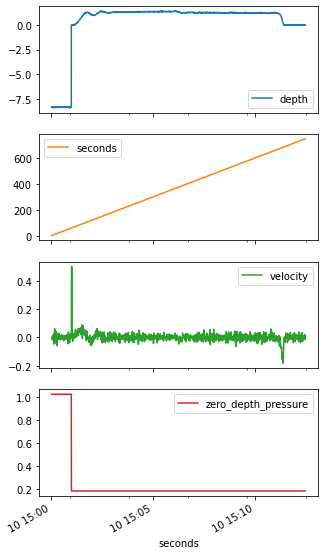

In [3]:
_ = bdata['depthFusion'].plot(subplots=True, figsize=(5,10))

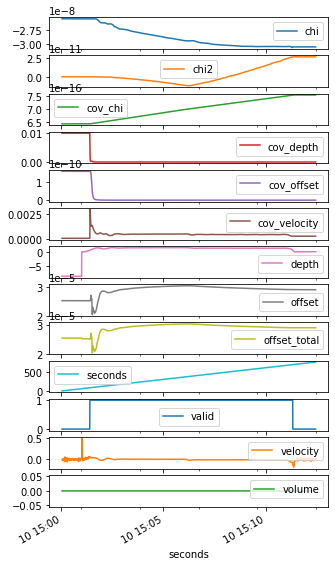

In [4]:
_ = bdata['kalman'].plot(subplots=True, figsize=(5,10))

In [5]:
# load config file
file = root_dir+'config_ifremer1.yaml'

def load_config(file):
    # should add arguments to overwrite config file content
    with open(file, 'r') as stream:
        cfg = yaml.load(stream)
    return cfg

cfg = load_config(file)
cfg

{'mission_file_name': 'mission_depth_only.xml',
 'physics': {'rho': 1020.0,
  'g': 9.81,
  'm': 13.5,
  'diam_collerette': 0.35,
  'screw_thread': 8.48e-05,
  'tick_per_turn': 1,
  'piston_diameter': 0.0195,
  'piston_max_value': 1415.0,
  'piston_speed_max_tick': 20,
  'piston_ref_eq': 1000},
 'driver': {'power': {'frequency': 0.2},
  'piston': {'frequency': 25.0,
   'divider_frequency': 5,
   'distance_fast_move': 100,
   'speed_fast_move_factor': 2.0,
   'speed_reset': 25,
   'speed_out_min': 25,
   'speed_in_min': 25,
   'speed_out_slope': 0.5,
   'speed_in_slope': 0.5,
   'speed_depth_layer': 5.0,
   'depth_max': 500.0,
   'depth_big_piston': 2.0,
   'tick_big_piston': 354,
   'speed_max': 50,
   'reached_switch_off': True,
   'error_interval': 6,
   'tick_max': 1500},
  'pressure_ext': {'frequency': 5},
  'pressure_int': {'frequency': 5, 'primary_i2c_address': True},
  'temperature_ext': {'frequency': 5}},
 'filter': {'depth_filter': {'frequency': 25,
   'filter_window_size': 6,


---
## look at regulation

In [7]:
cfg['physics']

{'rho': 1020.0,
 'g': 9.81,
 'm': 13.5,
 'diam_collerette': 0.35,
 'screw_thread': 8.48e-05,
 'tick_per_turn': 1,
 'piston_diameter': 0.0195,
 'piston_max_value': 1415.0,
 'piston_speed_max_tick': 20,
 'piston_ref_eq': 1000}

In [8]:
cfg['regulation']['depth_controller']

{'frequency': 25.0,
 'divider_frequency': 5,
 'root_regulation': -0.5,
 'limit_depth_controller': 0.2,
 'delta_velocity_lb': 0.0,
 'delta_velocity_ub': 0.0,
 'delta_position_lb': 0.0,
 'delta_position_ub': 0.0,
 'hysteresis_piston': 0.6,
 'speed_volume_sink': 2.0,
 'hold_depth_enable': False,
 'hold_depth_value_enter': 0.05,
 'hold_depth_value_exit': 0.0}

In [9]:
fl.regulation._control_feedback2?

Signature:
fl.regulation._control_feedback2(
    lbd1,
    lbd2,
    nu,
    delta,
    z,
    dz,
    d2z,
    z_t,
    gamma,
    A,
    B,
)
Docstring:
Control feedback of the float position
Parameters
----------

ldb1: float
    float control parameter 1 [s^-1]
ldb2: float
    float control parameter 2 [s^-2]
nu: float
    Travel velocity when the float is far from the target position [m.s^-1]
delta: float
    length scale that defines the zone of influence around the target depth [m]
z: float
    Position of the float, 0. at the surface and negative downward [m]
dz: float
    Vertical velocity of the float, negative for downward motions [m.s^-1]
d2z: float
    Vertical acceleration of the float, negative for downward accelerations [m.s^-2]
z_target: float
    Target depth [m]
gamma: float
    equivalent compressibility [m^2]
A, B: float
    A = g rho / [(1+a)m], B = c_1/[2(1+a)L]
File:      ~/code/cognac/cognac/float/regulation.py
Type:      function


In [13]:
f.

AttributeError: 'autonomous_float' object has no attribute 'ctrl'

In [19]:
f = fl.autonomous_float(model='Ifremer')
f.init_piston()

# cognac lib 
# self._B = self.c1/(2*self.Lv*(1+self.a))
#
# seabot:
#  const double Cf = M_PI*pow(diam_collerette/2.0, 2);
#  tick_to_volume = (screw_thread/tick_per_turn)*pow(piston_diameter/2.0, 2)*M_PI;
#  coeff_A = g*rho/m;
#  coeff_B = 0.5*rho*Cf/m;
ph = cfg['physics']
Cf = np.pi*(ph['diam_collerette']/2.)**2
B = 0.5*ph['rho']*Cf/ph['m']
f.Lv = f.c1/(2*B*(1+f.a))


# regulation

r = cfg['regulation']['depth_controller']
limit_velocity = 0.1 # from xml
approach_velocity = 1. # from xml

#ctrl = {'mode': 'feedback', 'dt': 5., 'dz_nochattering': 0.,
#      'nu': 2*target_velocity*2./np.pi, 'tau': 20., 'delta': .1,
#      'continuous': False}
ctrl = {'mode': 'feedback',
        'dt': 1/r['frequency'],
        'tau': 1/abs(r['root_regulation']),  # Set the root of feed-back regulation # s assesed by simulation
        'nu': limit_velocity*2./np.pi, # Set the limit speed : 3cm/s assesed by simulation
        'delta': approach_velocity, #length scale that defines the zone of influence around the target depth, assesed by simulation
        'gamma': f.gamma, #mechanical compressibility [1/dbar]
         }

f.init_control(ctrl, f.v, ctrl['dt'])
print(f)
f.ctrl

Piston max volume set from max displacement
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 11.63 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 9.13e+08 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 9.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 8.57e-02 mm        - smallest variation of translation motion for the p

Control parameters: 
  mode = feedback 
  dt = 4.00e-02 
  dz_nochattering = 0.00e+00 
  tau = 2.00e+00 
  nu = 6.37e-02 
  delta = 1.00e+00 
  continuous = 1.00e+00 

In [21]:
def get_u(f, z, dz, d2z, z_t, gamma):
    return fl._control_feedback2(f.ctrl.lbd1, f.ctrl.lbd2, 
                                 f.ctrl.nu, f.ctrl.delta, 
                                 z, dz, d2z, z_t, gamma,
                                 f.ctrl.A, f.ctrl.B)

In [33]:
def resample(dt, **kwargs):
    
z = -bdata['kalman']['depth']
dz = -bdata['kalman']['velocity']
z_t = bdata['mission']['depth']

piston_position = bdata['pistonState']['position']




# acceleration in seabot is deduced from dynamical equation:
#  double dx1 = -A*(x3+x4-(x5*x2+x6*pow(x2,2)))-B*x7*abs(x1)*x1;

#  x(0) = msg->velocity;
#  x(1) = msg->depth;
#  x(3) = msg->offset;
#  x(4) = msg->chi;
#  x(5) = msg->chi2;
#  x(6) = msg->cz;

#  const double x1 = x(0);
#  const double x2 = x(1);
#  const double x3 = x(2);
#  const double x4 = x(3);
#  const double x5 = x(4);
#  const double x6 = x(5);
#  const double x7 = x(6);

#            x(2) = -piston_position*tick_to_volume;

def get_d2z(f, kalman, piston_position):
    A, B = f.ctrl._A, f.ctrl._B
    x1 = kalman['velocity']
    x2 = kalman['depth']
    x3 = piston_position
    x4 = kalman['offset']
    x5 = kalman['chi']
    x6 = kalman['chi2']
    #x6 = kalman['cz']
    x7 = kalman['chi']*0.+1. # !!!!! cz is not outputted
    dx1 = -A*(x3+x4-(x5*x2+x6*x2**2))-B*x7*abs(x1)*x1;
    return -dx1

In [37]:
bdata

dict_keys(['regulationHeadingSetPoint', 'fix', 'pistonState', 'poseFusion', 'batteryFusion', 'iridiumSession', 'iridiumStatus', 'safetyDebug', 'kalman', 'safetyCpu', 'regulation', 'engineCmd', 'imu', 'sensorExt', 'sensorInt', 'pistonSpeed', 'mag', 'rosoutAgg', 'regulationHeading', 'euler', 'temperature', 'sensorIntFusion', 'safety', 'rosout', 'engine', 'battery', 'pistonVelocity', 'mission', 'pistonDistance', 'depthFusion', 'imuDebug', 'regulationWaypoint', 'pistonSetPoint'])

In [41]:
bdata['pistonState']

,enable_on,motor_on,motor_speed,position,position_set_point,state,switch_in,switch_out,seconds
seconds,,,,,,,,,
2020-06-10 15:00:34.198669989-17:00,0,1,50.0,0.00,0.0,1,0,1,34.198670
2020-06-10 15:00:34.388229236-17:00,0,1,50.0,0.00,0.0,1,0,1,34.388229
2020-06-10 15:00:34.588486979-17:00,0,1,50.0,0.00,0.0,1,0,1,34.588487
2020-06-10 15:00:34.788480296-17:00,0,1,50.0,0.00,0.0,1,0,1,34.788480
2020-06-10 15:00:34.988573145-17:00,0,1,50.0,0.00,0.0,1,0,1,34.988573
...,...,...,...,...,...,...,...,...,...
2020-06-10 15:12:27.032450020-17:00,0,1,50.0,1.25,0.0,1,0,0,747.032450
2020-06-10 15:12:27.233690770-17:00,0,1,50.0,1.25,0.0,1,0,0,747.233691
2020-06-10 15:12:27.432611647-17:00,0,1,50.0,1.25,0.0,1,0,0,747.432612


In [34]:
bdata['kalman']

,chi,chi2,cov_chi,cov_depth,cov_offset,cov_velocity,depth,offset,offset_total,seconds,valid,velocity,volume
seconds,,,,,,,,,,,,,
2020-06-10 15:00:02.459890902-17:00,-2.532532e-08,0.000000e+00,6.413719e-16,0.010000,1.603430e-10,0.000100,-8.363070,0.000025,0.000026,2.459891,0,0.000000,6.943538e-310
2020-06-10 15:00:02.659900158-17:00,-2.532532e-08,0.000000e+00,6.413719e-16,0.010000,1.603430e-10,0.000100,-8.365612,0.000025,0.000026,2.659900,0,0.000000,6.943538e-310
2020-06-10 15:00:02.859748685-17:00,-2.532532e-08,0.000000e+00,6.413719e-16,0.010000,1.603430e-10,0.000100,-8.357987,0.000025,0.000026,2.859749,0,0.000000,1.707697e-316
2020-06-10 15:00:03.059773722-17:00,-2.532532e-08,0.000000e+00,6.413719e-16,0.010000,1.603430e-10,0.000100,-8.380861,0.000025,0.000026,3.059774,0,0.000000,1.707697e-316
2020-06-10 15:00:03.259782508-17:00,-2.532532e-08,0.000000e+00,6.413719e-16,0.010000,1.603430e-10,0.000100,-8.365612,0.000025,0.000026,3.259783,0,0.000000,1.942612e-316
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-10 15:12:26.259780208-17:00,-3.062278e-08,2.696101e-11,7.546063e-16,0.000009,1.138028e-14,0.000314,0.008845,0.000029,0.000029,746.259780,0,0.019068,1.900905e-316
2020-06-10 15:12:26.459744982-17:00,-3.062278e-08,2.696101e-11,7.546063e-16,0.000009,1.138028e-14,0.000314,0.008845,0.000029,0.000029,746.459745,0,0.009528,1.900904e-316
2020-06-10 15:12:26.659507777-17:00,-3.062278e-08,2.696101e-11,7.546063e-16,0.000009,1.138028e-14,0.000314,0.001220,0.000029,0.000029,746.659508,0,-0.000007,1.900903e-316


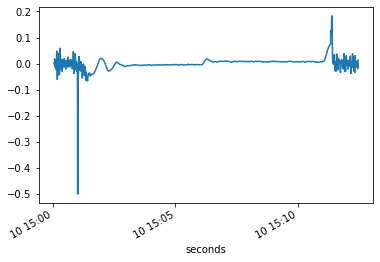

In [31]:
dz.plot()

In [ ]:
get_u()

In [11]:
p = np.arange(0,2,.1)
t = 15.*(p-p[-1])/(p[0]-p[-1]) - 16.*(p-p[0])/(p[0]-p[-1])
s = t*0.+30
w = fl.waterp(pressure=p, temperature=t, salinity=s, lon=6.,lat=40.) # 

Provided water profile at lon=6, lat=40

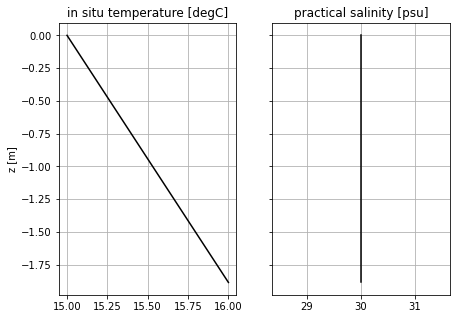

In [12]:
w

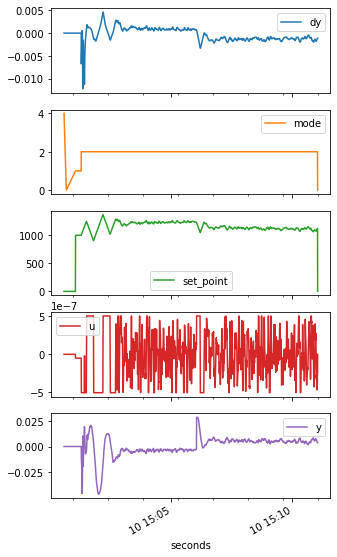

In [11]:
_ = bdata['regulation'].drop(columns='seconds').plot(subplots=True, figsize=(5,10))

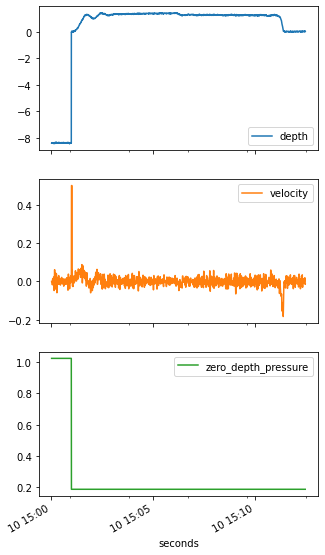

In [12]:
_ = bdata['depthFusion'].drop(columns='seconds').plot(subplots=True, figsize=(5,10))

---

## extract stratification

Sampling rate: 0.20s


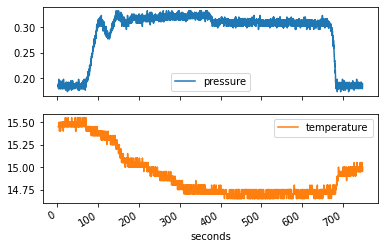

In [109]:
dt = bdata['sensorExt']['seconds'].diff()
print('Sampling rate: {:.2f}s'.format(dt[dt>0].mean()))
_ = bdata['sensorExt'][dt>0].plot(x='seconds', subplots=True)

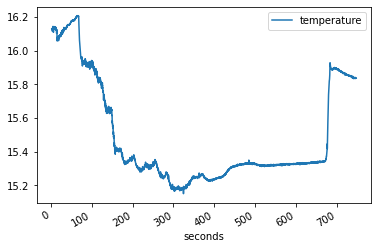

In [110]:
dv = abs(bdata['temperature']['temperature'].diff())
threshold = dv.quantile(.99)
_ = bdata['temperature'][dv<threshold].plot(x='seconds', subplots=True)

In [156]:
# merge pressure and temperature data

dv = abs(bdata['temperature']['temperature'].diff())
T = (bdata['temperature'][dv<threshold]['temperature']
     .resample('1s')
     .median()
    )

dt = bdata['sensorExt']['seconds'].diff()
D = (bdata['sensorExt'][dt>0]['pressure']
     .resample('1s')
     .median()
     .rename('depth')
     *1e5/(1000*9.81)
    )
D = D - D.min()

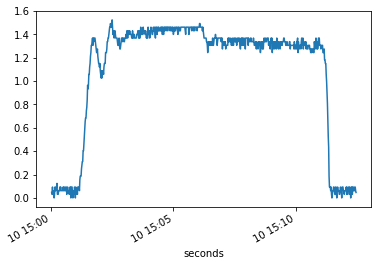

In [159]:
_ = D.plot()

In [160]:
df = pd.concat([T, D], axis=1)

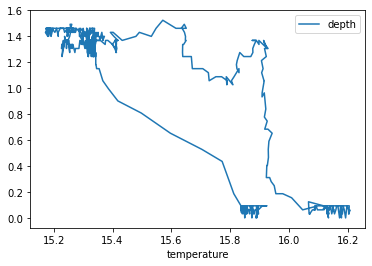

In [161]:
df.plot(x='temperature')

/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


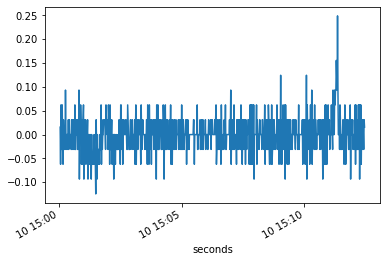

In [190]:
def get_depth_profile(df, threshold=.02, dz=.1):
    ''' select ascent and bin by depth
    '''
    z = -df['depth']
    #dt = df.index.to_series().diff().mean().total_seconds()
    dt = df.index.to_series().diff().apply(lambda x: x.total_seconds())
    # compute speed of descent
    dzdt = z.diff()/dt
    #
    df = df[dzdt>threshold] # ascending values only
    df['z'] = z
    dzdt.plot(subplots=True)
    #
    z_rounded = np.round(z/dz).rename('bins')
    df = df.groupby(by=z_rounded).mean()
    #
    df = (df
          .drop(columns='depth')
          .reset_index()
          .drop(columns='bins')
          .set_index('z')
         )
    return df
        
pr = get_depth_profile(df)

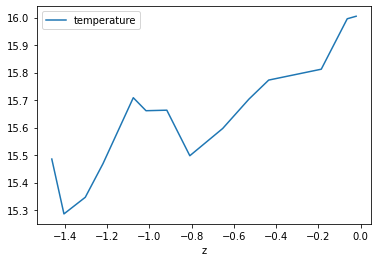

In [191]:
pr.plot()

In [13]:
bdata.keys()

dict_keys(['regulationHeadingSetPoint', 'fix', 'pistonState', 'poseFusion', 'batteryFusion', 'iridiumSession', 'iridiumStatus', 'safetyDebug', 'kalman', 'safetyCpu', 'regulation', 'engineCmd', 'imu', 'sensorExt', 'sensorInt', 'pistonSpeed', 'mag', 'rosoutAgg', 'regulationHeading', 'euler', 'temperature', 'sensorIntFusion', 'safety', 'rosout', 'engine', 'battery', 'pistonVelocity', 'mission', 'pistonDistance', 'depthFusion', 'imuDebug', 'regulationWaypoint', 'pistonSetPoint'])

In [ ]:
bdata['temperature'].rename